# Keras based GRU Network

## Prepare dataset

Reformat dataset to be int format
```
caption | valence_class
caption | {negative,neutral,positive}
```

In [8]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
oasis_csv_path = "dataset/metadata/OASIS.csv"


human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
neutralLow = 3.0 
neutralHigh = 5.0
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'
neutralLow = 3.0 
neutralHigh = 5.0
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Train and Val set



In [40]:
from shutil import rmtree

trainValSplitRatio = 0.75

def delete_file(filePath):
    if os.path.isfile(filePath):
        os.remove(filePath)

def create_train_dev_set(isRunningForHumanCaption, dataset_path, delimeter="|"):
    if isRunningForHumanCaption:
        caption_csv_path = human_output_caption_to_label_csv_path
        prefix = "human"
    else:
        caption_csv_path = auto_output_caption_to_label_csv_path
        prefix = "auto"
    
    
    dataset_groups=["train", "val"]
    if not os.path.isdir(dataset_path):
        os.makedirs(dataset_path)

    captionToLabelDf = dt.read_caption_to_label_csv_into_dataframe(caption_csv_path)
    captionToLabelDf.shape
    captionToLabelDf.head()

    random.seed(1)
    trainCount = 0
    valCount = 0
    for index, row in captionToLabelDf.iterrows():
        caption = row['caption']
        label = row['label']
        prob = random.uniform(0, 1)
        if prob > trainValSplitRatio:
            dGroup = "val"
            valCount += 1
        else:
            dGroup = "train"
            trainCount += 1
        filename = prefix + "-" + dGroup + ".csv"
        filePath = dataset_path + filename
        if index == 0:
            trainFile = prefix + "-" + "train" + ".csv"
            delete_file(dataset_path + trainFile)
            valFile = prefix + "-" + "val" + ".csv"
            delete_file(dataset_path + valFile)
            
        with open(filePath,  'a', encoding="utf8") as f:
            f.write(caption + delimeter + label + "\n")
    print("Train count: ", trainCount)
    print("Val count: ", valCount)

    
caption_to_label_dataset_path = "dataset/caption-lstm/"

# Create Train and Val set for human generated captions
isRunningForHumanCaption = True
create_train_dev_set(isRunningForHumanCaption, caption_to_label_dataset_path)

# Create Train and Val set for auto generated captions
isRunningForHumanCaption = False
create_train_dev_set(isRunningForHumanCaption, caption_to_label_dataset_path)

Train count:  664
Val count:  236
Train count:  664
Val count:  236


## Set Keras to use Tensorflow GPU in the backend

In [ ]:
import tensorflow as tf
from keras import backend as K

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 2
    num_CPU = 8
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

## Loading Fasttext Embeddings

You can download fasttext word vectors from here:

https://fasttext.cc/docs/en/english-vectors.html    
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
    

In [4]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense
from keras.layers import GRU, Bidirectional
from keras.layers.core import Dropout
from keras.layers.core import Masking
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.utils import multi_gpu_model
from keras import regularizers
import keras
import os
import io
import numpy as np
import tensorflow as tf
from gensim.models import word2vec
import pandas as pd
# from fastText import load_model
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing import text
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time
%matplotlib inline 

def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}


fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
wordToVec = load_embedding(fasttext_embedding_path)



/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


embedding size : 999995
embedding dimension : (300,)


## Results

# Try cross validation

Epoch 300/300
663/663 [==============================] - 2s 3ms/step - loss: 0.1011 - acc: 0.9789 - val_loss: 1.9239 - val_acc: 0.6426

best_val_acc:  0.7148936180358237
filename adidas-0.7149-1527322080
Total time passed for training 9.198103360335033


In [133]:
from keras import regularizers


def _build_model(num_of_classes, embedding_dim, hidden_layer_dim, dropout, recurrent_dropout, final_activation): 
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, embedding_dim)))
    model.add(Bidirectional(GRU(hidden_layer_dim, return_sequences=True, 
                                dropout=dropout, recurrent_dropout=recurrent_dropout), merge_mode='concat'))
    model.add(Bidirectional(GRU(hidden_layer_dim, dropout=dropout, 
                                recurrent_dropout=recurrent_dropout), merge_mode='concat'))
    # Adding new dense layers
#     model.add(Dense(hidden_layer_dim * 16, activation='relu'))
#     model.add(Dropout(dropout))
#     model.add(Dense(hidden_layer_dim * 16,  activation='relu'))
#     model.add(Dropout(dropout))
#     model.add(Dense(hidden_layer_dim * 8, activation='relu'))
#     model.add(Dropout(dropout))
#     model.add(Dense(hidden_layer_dim * 8, activation='relu'))
#     model.add(Dropout(dropout))
    model.add(Dense(hidden_layer_dim * 4, kernel_regularizer=regularizers.l2(0.08), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_layer_dim * 2, activation='relu'))
    model.add(Dense(num_of_classes, activation=final_activation))
    # loss = 'sparse_categorical_crossentropy' -> index -> 2
    # loss = 'categorical_crossentropy' -> one_hot -> [0,0,1,0,0,0]
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(), metrics=['accuracy'])
    return model


def get_word_embedding(word):
    word = word.lower()
    if word in wordToVec:
        return wordToVec[word]
    else:
        return np.zeros(embedding_dimension,)
    
def get_sequence_embedding(words, max_seq_len=30):
    if len(words) <= max_seq_len:
        # Add padding
        x_seq = np.array([get_word_embedding(word) for word in words])
        x_seq = np.lib.pad(x_seq, ((0,max_seq_len-x_seq.shape[0]),(0,0)), 'constant')
    else:
        x_seq = []
        for i in range(max_seq_len):
            x_seq.append(get_word_embedding(words[i]))
        x_seq = np.array(x_seq)
    return x_seq
        
def load_dataset(file_path):
    df = pd.read_csv(file_path, sep="|")
    sentences = []
    label_index = []
    num_of_classes = 0
    for i in range(len(df)):
        sentence = df.iloc[:,0][i]  # first column of data frame
        words = sentence.split(" ")
        sentence_embedding = get_sequence_embedding(words, max_seq_len)
        sentences.append(sentence_embedding)
        label = df.iloc[:,1][i]  # second column of data frame
        if label in class_to_index:
            label_index.append(class_to_index[label])
        else:
            num_of_classes += 1
            class_to_index[label] = num_of_classes - 1
            index_to_class[num_of_classes - 1] = label
            label_index.append(class_to_index[label])
    X_train = np.array(sentences)
    y_train = np.array(label_index)
    return (X_train, y_train, num_of_classes)

def convert_index_to_one_hot(y_train_index, num_of_classes):
    y_train = np.zeros((y_train_index.shape[0],num_of_classes))
    y_train[range(y_train_index.shape[0]),y_train_index] = 1
    return y_train


def generate_model_name(filename, best_acc_val):
    timestamp = str(time.time()).split(".")[0]
    best_acc_val = round(best_acc_val,4)
    filename += "-" + str(best_acc_val) + "-" + timestamp
    return filename
    

def train():
    X_train, y_train_index, num_of_classes = load_dataset(dataset_path)
    y_train = convert_index_to_one_hot(y_train_index, num_of_classes) 
    
    print('X_train shape : %s' % (X_train.shape,))
    print('y_train shape : %s' % (y_train.shape,))
    print('number of classes : %d' % num_of_classes)
    print(X_train[0])
    print(y_train[0])
    print(index_to_class)

    X_val, y_val_index, _ = load_dataset(val_dataset_path)
    y_val = convert_index_to_one_hot(y_val_index, num_of_classes) 
    
    model = _build_model(num_of_classes, 
                         embedding_dim=300, 
                         hidden_layer_dim=64, 
#                          dropout=0.65, 
#                          recurrent_dropout=0.65,
                         dropout=0.7, 
                         recurrent_dropout=0.5,
                         final_activation='softmax')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.03, 
                                  patience=15, 
                                  min_lr=0.00001, verbose=1)
    
    history = {}
    filename = ""
    # checkpoint
    filepath="model/weights.best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    callbacks_list = [ checkpoint, early_stopping] #reduce_lr, 
    with tf.Session() as sess:
        history = model.fit(x=X_train,
                  y=y_train, 
                  batch_size=32, 
                  epochs=300, 
                  verbose=1, 
                  validation_data = (X_val, y_val),
                  shuffle=True
                  ,callbacks=callbacks_list)        
        val_acc_list = history.history['val_acc']
        best_val_acc =  max(val_acc_list)
        filename = "hec" 
        filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
    
    best_val_acc = -1
    val_acc_list = history.history['val_acc']
    best_val_acc =  max(val_acc_list)
    print("best_val_acc: ", best_val_acc)
    #filename = generate_model_name(filename, best_val_acc)
    print("filename",filename)
    plot_model(model, to_file= filename +'.png', show_shapes=True, show_layer_names=True)#
    return history


def predict():
    model = keras.models.load_model('model/intent_model_ricodataset.h5')
    sentence = "www.google.com"
    X_train = []
    X_train.append(get_sequence_embedding(sentence.split(" "),max_seq_len))
    X_train = np.array(X_train)
    print(X_train.shape)
    result = model.predict(X_train)
    print(result)
    print(index_to_class)
    for i in index_to_class:
        print("%s : %.3f%%" % (index_to_class[i], result[0][i] * 100))

def text_pre_processing(document):
    document = text.text_to_word_sequence(document, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')
    print(document)
    return document


dataset_path = caption_to_label_dataset_path + "/" +'human-train.csv'
val_dataset_path = caption_to_label_dataset_path + "/" +'human-val.csv'
embedding_dimension = 300
class_to_index = {}
index_to_class = {}
max_seq_len = 40
start = time.time()
history = train()
end = time.time()
print("Total time passed for training", (end-start)/60)
# predict()
# text_pre_processing("hello&nbsp;hi")

X_train shape : (663, 40, 300)
y_train shape : (663, 3)
number of classes : 3
[[ 0.0134  0.0171 -0.0344 ...  0.1915  0.2418  0.0458]
 [-0.083   0.1102  0.0196 ...  0.1866  0.0824  0.1139]
 [-0.007   0.0228 -0.1499 ...  0.1013 -0.0968  0.0194]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[1. 0. 0.]
{0: 'neutral', 1: 'negative', 2: 'positive'}
Train on 663 samples, validate on 235 samples
Epoch 1/300
663/663 [==============================] - 24s 37ms/step - loss: 11.8462 - acc: 0.3982 - val_loss: 9.0929 - val_acc: 0.4553

Epoch 00001: val_acc improved from -inf to 0.45532, saving model to model/weights.best.h5
Epoch 2/300
663/663 [==============================] - 2s 2ms/step - loss: 7.2592 - acc: 0.4676 - val_loss: 5.5710 - val_acc: 0.4553

Epoch 00002: val_acc did not improve
Epoch 3/300
663/663 [==============================] - 2s 2ms/step - loss: 4.4766 - ac

663/663 [==============================] - 2s 2ms/step - loss: 0.8214 - acc: 0.6667 - val_loss: 0.8359 - val_acc: 0.6426

Epoch 00043: val_acc did not improve
Epoch 44/300
663/663 [==============================] - 2s 2ms/step - loss: 0.8025 - acc: 0.6787 - val_loss: 0.7559 - val_acc: 0.6894

Epoch 00044: val_acc did not improve
Epoch 45/300
663/663 [==============================] - 2s 2ms/step - loss: 0.8516 - acc: 0.6214 - val_loss: 0.8011 - val_acc: 0.6638

Epoch 00045: val_acc did not improve
Epoch 46/300
663/663 [==============================] - 2s 2ms/step - loss: 0.8367 - acc: 0.6365 - val_loss: 0.8162 - val_acc: 0.6298

Epoch 00046: val_acc did not improve
Epoch 47/300
663/663 [==============================] - 2s 2ms/step - loss: 0.8131 - acc: 0.6621 - val_loss: 0.7886 - val_acc: 0.6766

Epoch 00047: val_acc did not improve
Epoch 48/300
663/663 [==============================] - 2s 2ms/step - loss: 0.7911 - acc: 0.6848 - val_loss: 0.8231 - val_acc: 0.6340

Epoch 00048: val_a

663/663 [==============================] - 2s 2ms/step - loss: 0.6561 - acc: 0.7602 - val_loss: 0.7612 - val_acc: 0.7064

Epoch 00090: val_acc did not improve
Epoch 91/300
663/663 [==============================] - 2s 2ms/step - loss: 0.6424 - acc: 0.7451 - val_loss: 0.7403 - val_acc: 0.6851

Epoch 00091: val_acc did not improve
Epoch 92/300
663/663 [==============================] - 2s 2ms/step - loss: 0.6980 - acc: 0.7240 - val_loss: 0.8232 - val_acc: 0.6511

Epoch 00092: val_acc did not improve
Epoch 93/300
663/663 [==============================] - 2s 2ms/step - loss: 0.6624 - acc: 0.7496 - val_loss: 0.7666 - val_acc: 0.6851

Epoch 00093: val_acc did not improve
Epoch 94/300
663/663 [==============================] - 2s 2ms/step - loss: 0.6550 - acc: 0.7511 - val_loss: 0.7512 - val_acc: 0.6979

Epoch 00094: val_acc did not improve
Epoch 95/300
663/663 [==============================] - 2s 2ms/step - loss: 0.6534 - acc: 0.7526 - val_loss: 0.7450 - val_acc: 0.6894

Epoch 00095: val_a

## Plot accuracy graph

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
best_val_acc 0.7191489371847599
best_train_acc 0.7782805419975096
lowest_val_loss 0.7186885812181107
lowest_train_loss 0.6235453566454834


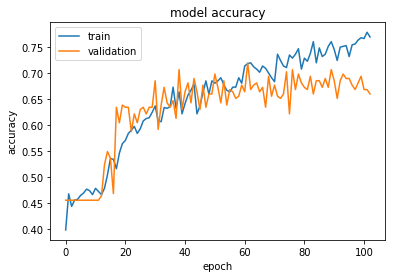

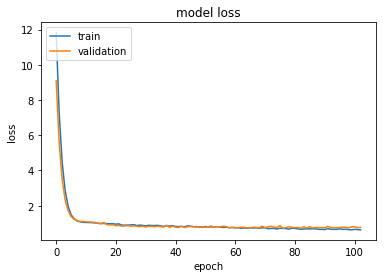

In [134]:
def plot_model_accuracy(history):
    filename = "hec" 
    filename = generate_model_name(filename + "-acc", max(history.history['val_acc']))
    fig = plt.figure()
    print(history.history.keys())
    print("best_val_acc", max(history.history['val_acc']))
    print("best_train_acc", max(history.history['acc']))
    print("lowest_val_loss", min(history.history['val_loss']))
    print("lowest_train_loss", min(history.history['loss']))
    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    fig.savefig("model/" + filename + ".png") 
    
    # "Loss"
    fig = plt.figure()
    filename = "hec" 
    filename = generate_model_name(filename + "-loss", min(history.history['val_loss']))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    fig.savefig("model/" + filename + ".png") 

plot_model_accuracy(history)    

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])
best_val_acc 0.7404255331830776
best_train_acc 0.8220211161387632
lowest_val_loss 0.6062451817887895
lowest_train_loss 0.4487598615264461


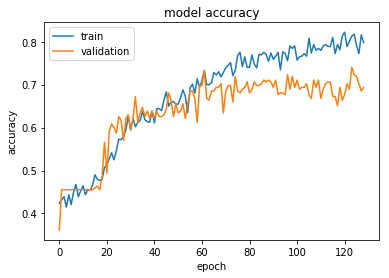

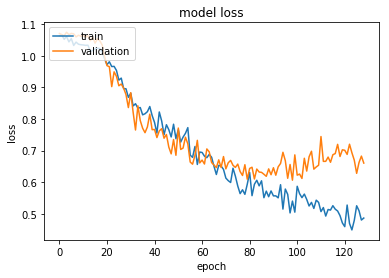

In [65]:
plot_model_accuracy(history)